todo:

- correlations
- Cross validations 
- Redandency

## Data Understanding

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statistics
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
set1_df = pd.read_csv(r'..\data\set9_it1.csv')
set2_df = pd.read_csv(r'..\data\set9_it2.csv')
set3_df = pd.read_csv(r'..\data\set9_it3.csv')

In [4]:
print(set1_df.isna().sum())
print(set2_df.isna().sum())
print(set3_df.isna().sum())


DI                  0
TradeValue          0
RealmType           0
Enclave             0
LivingQuarters    117
ParcelSize          0
ParcelSizeUnit      0
dtype: int64
DI                     0
StructuralIntegrity    0
ExteriorCharm          0
dtype: int64
DI                0
Craftsmanship     0
EraConstructed    0
dtype: int64


### Checking new data before cleaning

In [5]:
## if anyone has any idea what to check do it here 

## Data Preperation

In [6]:
# deleteing the rows with missing values 
set1_df.dropna(inplace=True)
# removes the duplicate rows in place
set1_df.drop_duplicates(inplace=True)
set2_df.drop_duplicates(inplace=True)
set3_df.drop_duplicates(inplace=True)

# Removing parcelSize below one
set1_df.drop(set1_df[set1_df['ParcelSize'] < 1].index, inplace=True)

# Cleaning capitalisation 
set1_df['Enclave'] = set1_df['Enclave'].str.capitalize()

# Replacing typos after manual inspection
set1_df['Enclave'] = set1_df['Enclave'].replace('Sunspires', 'Sunspire')
set1_df['Enclave'] = set1_df['Enclave'].replace('Dragonspires', 'dragonspire')

# Converting incosintent metrics
SQFT_TO_SQM = 0.092903

set1_df.loc[set1_df["ParcelSizeUnit"] == "sqft", "ParcelSize"] *= SQFT_TO_SQM
set1_df.loc[set1_df["ParcelSizeUnit"] == "sqft", "ParcelSizeUnit"] = "sqm"


In [7]:
df = set1_df.merge(set2_df, left_on='DI', right_on='DI')
df = df.merge(set3_df, left_on='DI', right_on='DI')

#### Try both alrogithms 

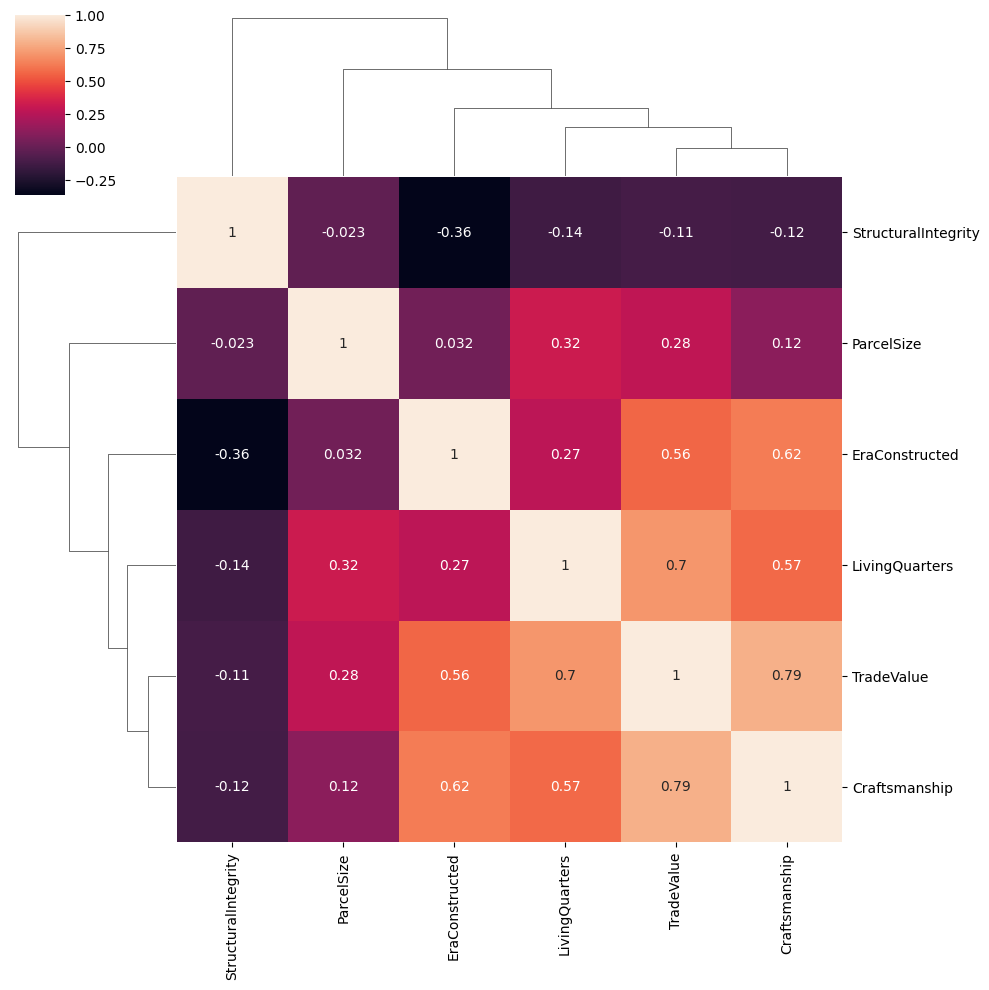

In [26]:
sns.clustermap(
	df.filter(items=[col for col in df.columns if col not in ['RealmType','Enclave','ParcelSizeUnit','ExteriorCharm','DI']]).corr(),
	annot=True
	)
	